In [21]:
import pandas as pd
import numpy as np
import re

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data_1 = pd.read_csv('bina_az_02102023.csv')
data_2 = pd.read_csv('bina_az_new.csv')
data_3 = pd.read_csv('bina_az_old.csv')
frames = pd.concat([data_1, data_2,data_3], copy=False,ignore_index=True,)
frames = frames.reset_index(drop=True)
frames=frames.drop_duplicates(keep='last')
frames=frames.dropna(ignore_index=True)

In [3]:
frames.head()

,id,link,view,updated,title,seller_type,price,currency,description,category,flat_number,area,room_count,documents,is_repair
0,Elanın nömrəsi: 3792340,https://bina.az/items/3792340,"Yeniləndi: Bugün 10:01 ,Baxışların sayı: 327",Yeniləndi: Bugün 10:01,"Satılır 2 otaqlı yeni tikili 65 m², Şah İsmayı...",vasitəçi (agent),198 000,AZN,"TƏCİLİ SATILIR,KİRAYƏ VERMƏK ÜÇÜN İDEAL VARİAN...",Yeni tikili,3 / 17,65 m²,2.0,var,var
1,Elanın nömrəsi: 3803498,https://bina.az/items/3803498,"Yeniləndi: Bugün 10:00 ,Baxışların sayı: 287",Yeniləndi: Bugün 10:00,"Satılır 3 otaqlı yeni tikili 95 m², 28 May m.",vasitəçi (agent),245 000,AZN,"Təcili.. Mərkəzdə, Azadlıq Prospekti, 28 May M...",Yeni tikili,5 / 19,95 m²,3.0,var,var
2,Elanın nömrəsi: 3812351,https://bina.az/items/3812351,"Yeniləndi: Bugün 09:59 ,Baxışların sayı: 129",Yeniləndi: Bugün 09:59,"Satılır 2 otaqlı yeni tikili 50 m², Nəsimi r.",vasitəçi (agent),159 000,AZN,"QAZLI VƏ YAŞAYİŞLI !!!,Yüksək keyfiyətlə inşa ...",Yeni tikili,6 / 16,50 m²,2.0,yoxdur,var
3,Elanın nömrəsi: 3812704,https://bina.az/items/3812704,"Yeniləndi: Bugün 09:56 ,Baxışların sayı: 54",Yeniləndi: Bugün 09:56,"Satılır 4 otaqlı yeni tikili 153 m², Əhmədli q.",vasitəçi (agent),335 000,AZN,TƏCİLİ ! SATILIR. 4 otaqlı Əla təmirlidir əşya...,Yeni tikili,10 / 20,153 m²,4.0,var,var
4,Elanın nömrəsi: 3743518,https://bina.az/items/3743518,"Yeniləndi: Bugün 09:56 ,Baxışların sayı: 198",Yeniləndi: Bugün 09:56,"Satılır 3 otaqlı yeni tikili 120 m², Nəsimi m.",vasitəçi (agent),224 000,AZN,"Binəqədi rayonu, 6-ci mikrorayon , NƏSİMİ MET...",Yeni tikili,9 / 18,120 m²,3.0,var,var


## is_near_metro

In [4]:
frames['is_near_metro'] = (frames['description'].str.contains('m\.', case=False)|frames['description'].str.contains('metro', case=False)).astype(int)

## Seller type

In [5]:
frames = frames.drop(frames[frames['seller_type'] == 'seller_type'].index)
frames['seller_type_encoded'] = frames['seller_type'].replace({'mülkiyyətçi': 1 ,'vasitəçi (agent)': 0 })

## Category

In [6]:
frames['category_encoded'] = frames['category'].replace({'Yeni tikili': 1, 'Köhnə tikili': 0})

## Flat

In [7]:
frames[['flat', 'total_flat']] = frames['flat_number'].str.split(' / ', expand=True).astype(int)

## Area

In [8]:
def remove_non_numeric_and_convert_to_float(value):
    numeric_part = re.sub(r'[^\d.]', '', value)
    if numeric_part:
        return float(numeric_part)
    else:
        return None
frames['area_converted'] = frames['area'].apply(remove_non_numeric_and_convert_to_float)

## Room count

In [9]:
frames['room_count'] = frames['room_count'].astype(int)

## Document

In [10]:
frames['documents_encoded'] = frames['documents'].replace({'var': 1, 'yoxdur': 0})

## Is repaired

In [11]:
frames['is_repair_encoded'] = frames['is_repair'].replace({'var': 1, 'yoxdur': 0})

## Price and Currency

In [12]:
frames['price'] = frames['price'].str.replace(' ', '', regex=True)
frames['price'] = frames['price'].astype(int)

In [13]:
frames['currency'].unique()

array(['AZN'], dtype=object)

## Feature selection

In [14]:
frames.columns

Index(['id', 'link', 'view', 'updated', 'title', 'seller_type', 'price',
       'currency', 'description', 'category', 'flat_number', 'area',
       'room_count', 'documents', 'is_repair', 'is_near_metro',
       'seller_type_encoded', 'category_encoded', 'flat', 'total_flat',
       'area_converted', 'documents_encoded', 'is_repair_encoded'],
      dtype='object')

In [15]:
frames=frames[['seller_type_encoded','flat','total_flat','area_converted', 'category_encoded' , 'documents_encoded' ,'is_repair_encoded' ,'is_near_metro','price']].drop_duplicates(ignore_index=True)

## Modelling

In [16]:
data = frames
X = data.drop(columns=['price'])
y = data['price'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,  
    max_depth=3,
    objective='reg:squarederror')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print("Model perforamnce metrics")
print("-----------------------")
print(f"R-squared: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print("-----------------------")

Model perforamnce metrics
-----------------------
R-squared: 0.67
Root Mean Squared Error: 108165.35
Mean Absolute Error: 49812.17
-----------------------


## Deployment from actual dataframe

In [18]:
data = frames

def train_xgboost_model(data):
    X = data.drop(columns=['price'])  
    y = data['price'] 
    model = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        objective='reg:squarederror')
    model.fit(X, y)
    return model

def deploy_first_row(model, data):
    first_row = data.iloc[0]
    actual_price = first_row['price']
    prediction_data = first_row.drop(['price']).to_frame().T
    predicted_price = model.predict(prediction_data)
    predicted_price = predicted_price[0]
    return actual_price, predicted_price
trained_model = train_xgboost_model(data)
actual_price, predicted_price = deploy_first_row(trained_model, data)
print('Inputs from first row :')
print( data.iloc[0])
print(f"Actual Price for the First Row: {actual_price:.2f}")
print(f"Predicted Price for the First Row: {predicted_price:.2f}")

Inputs from first row :
seller_type_encoded         0.0
flat                        3.0
total_flat                 17.0
area_converted             65.0
category_encoded            1.0
documents_encoded           1.0
is_repair_encoded           1.0
is_near_metro               1.0
price                  198000.0
Name: 0, dtype: float64
Actual Price for the First Row: 198000.00
Predicted Price for the First Row: 152222.52


## Feature Importance

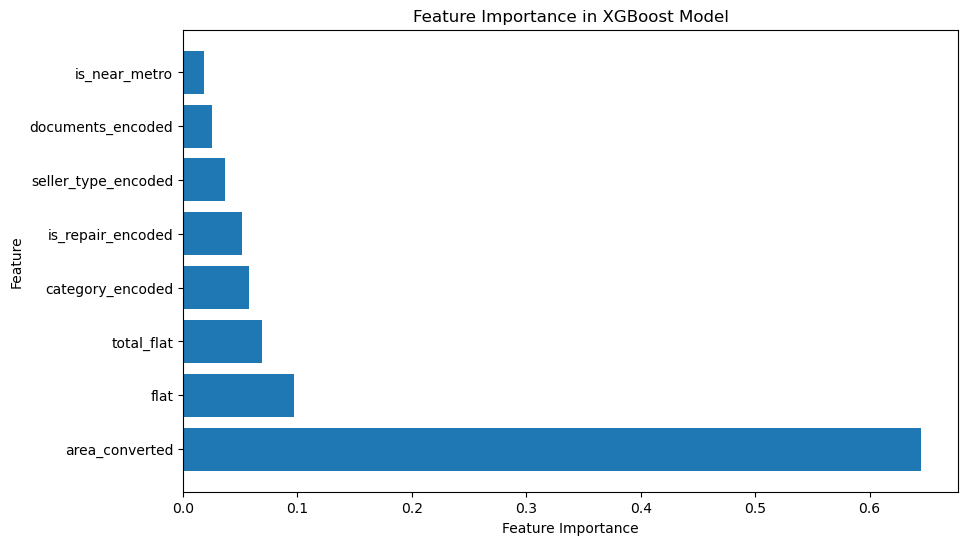

In [22]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_feature_importance = sorted_feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_feature_importance['Feature'], top_10_feature_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()